# CLUSTER K MEANS

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math
from math import pi
from sklearn import metrics
#Prepocessing per clustering: scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler #ultimo per otuliers: mantiene outliers considerando il range interquartile

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
from yellowbrick.cluster import KElbowVisualizer
import nltk





In [2]:
df = pd.read_csv("normative.csv", skipinitialspace=True)

# Prepocessing del dataset

- **Feature selection**: Selezione delle features da analizzare necessarie per descrivere i samples:
    - si eliminato le features ridondanti ovvero aventi correlazione > 0.9
    - si eliminano le features irrilevanti per l'analisi
- **Normalizzazione**

Per vedere quali feature eliminare, calcolo le correlazioni ed elimino quelle > 0.9 

In [3]:
cr = df.corr('spearman')
cr

,length,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,polysemy,frequency_log
length,1.000000,0.147804,0.053738,0.007002,-0.202149,-0.202792,-0.141403,0.412430,0.318125,-0.002198,-0.249338,-0.244366
arousal,0.147804,1.000000,0.354573,0.356341,-0.236691,-0.080643,0.167961,-0.004926,0.514712,-0.106969,-0.084989,0.069344
valence,0.053738,0.354573,1.000000,0.702252,0.042002,0.091276,0.294600,-0.188121,0.121232,-0.429474,0.000449,0.300823
dominance,0.007002,0.356341,0.702252,1.000000,0.042363,0.080612,0.234658,-0.141472,0.098469,-0.111078,0.051475,0.222038
concreteness,-0.202149,-0.236691,0.042002,0.042363,1.000000,0.903587,0.097511,-0.387694,-0.400490,0.141523,0.112280,0.025737
imageability,-0.202792,-0.080643,0.091276,0.080612,0.903587,1.000000,0.209765,-0.498524,-0.319086,0.063690,0.101208,0.023597
familiarity,-0.141403,0.167961,0.294600,0.234658,0.097511,0.209765,1.000000,-0.670507,0.045278,-0.217116,0.104050,0.580772
aoa,0.412430,-0.004926,-0.188121,-0.141472,-0.387694,-0.498524,-0.670507,1.000000,0.224328,0.144490,-0.180417,-0.412964
semsize,0.318125,0.514712,0.121232,0.098469,-0.400490,-0.319086,0.045278,0.224328,1.000000,0.148675,-0.137745,0.162738
gender,-0.002198,-0.106969,-0.429474,-0.111078,0.141523,0.063690,-0.217116,0.144490,0.148675,1.000000,0.025161,-0.075814


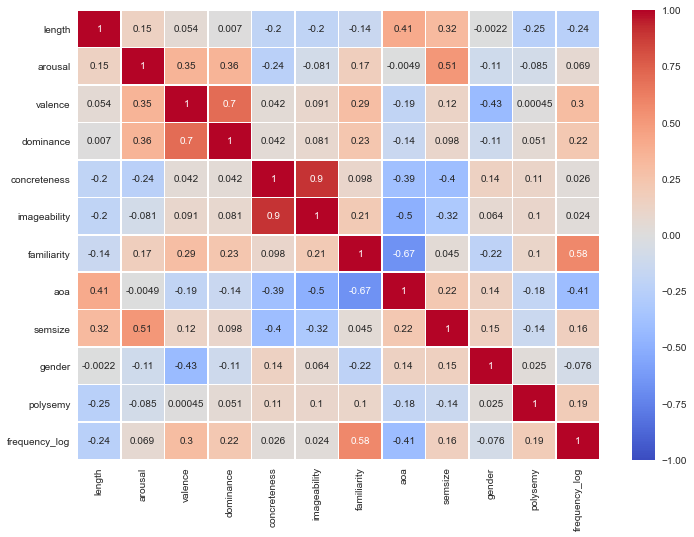

In [69]:
sns.heatmap(df.corr('spearman'),annot = True, linewidths=.5, cmap= 'coolwarm', vmin=-1, vmax=1)
plt.show()

In [70]:
#elimino le var con correlazione > 0.9
cr_new = cr[(cr > 0.9) | (cr < -0.9)]
cr_new

,length,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,polysemy,frequency_log
length,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arousal,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
valence,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dominance,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
concreteness,NaN,NaN,NaN,NaN,1.000000,0.903587,NaN,NaN,NaN,NaN,NaN,NaN
imageability,NaN,NaN,NaN,NaN,0.903587,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
familiarity,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
aoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
semsize,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [71]:
#elimino le var con correlazione > 0.9
cr_new = cr[(cr > 0.9) | (cr < -0.9)]
cr_new

,length,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,polysemy,frequency_log
length,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arousal,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
valence,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dominance,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
concreteness,NaN,NaN,NaN,NaN,1.000000,0.903587,NaN,NaN,NaN,NaN,NaN,NaN
imageability,NaN,NaN,NaN,NaN,0.903587,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
familiarity,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
aoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
semsize,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


Seleziono le feature per il cluster:
- elimino 'imageability' perché molto correlata con 'concreteness' (0.9) e poco correlata con la polisemia
- elimino 'polysemy' perché categorica
- elimino la lunghezza

In [4]:

#attr_cluster = ['length', 'valence', 'dominance', 'concreteness', 'aoa', 'semsize']    # s = 0.25   
#attr_cluster = ['length', 'valence', 'dominance', 'concreteness', 'familiarity', 'aoa', 'semsize']    #originale con s = 0.23
#attr_cluster = ['length', 'valence', 'dominance', 'concreteness', 'aoa'] 
#attr_cluster = ['length', 'valence', 'dominance', 'concreteness'] 
#attr_cluster = ['valence', 'dominance', 'concreteness'] 
attr_cluster = ['arousal', 'valence', 'dominance', 'concreteness', 'familiarity', 'aoa', 'semsize', 'gender', 'frequency_log']    
X = df[attr_cluster]

X_cat = df.drop(columns = ['word','length','arousal','valence', 'dominance','concreteness', 'imageability', 'aoa','familiarity', 'semsize', 'gender', 'frequency_log'  ])
X_num = df[attr_cluster]

scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X) 

X.head()


,arousal,valence,dominance,concreteness,familiarity,aoa,semsize,gender,frequency_log
0,4.200,2.864,4.333,5.455,2.382,6.760,4.652,5.391,5.204321
1,3.125,5.781,4.667,5.906,3.324,5.177,5.121,3.303,6.625813
2,3.273,5.250,5.235,3.286,5.121,5.543,2.667,3.971,5.146454
3,4.194,3.767,4.419,3.367,3.971,6.233,4.679,5.167,5.093852
4,3.846,3.880,4.800,3.292,3.097,6.407,5.083,4.571,5.107695


### Elbow method

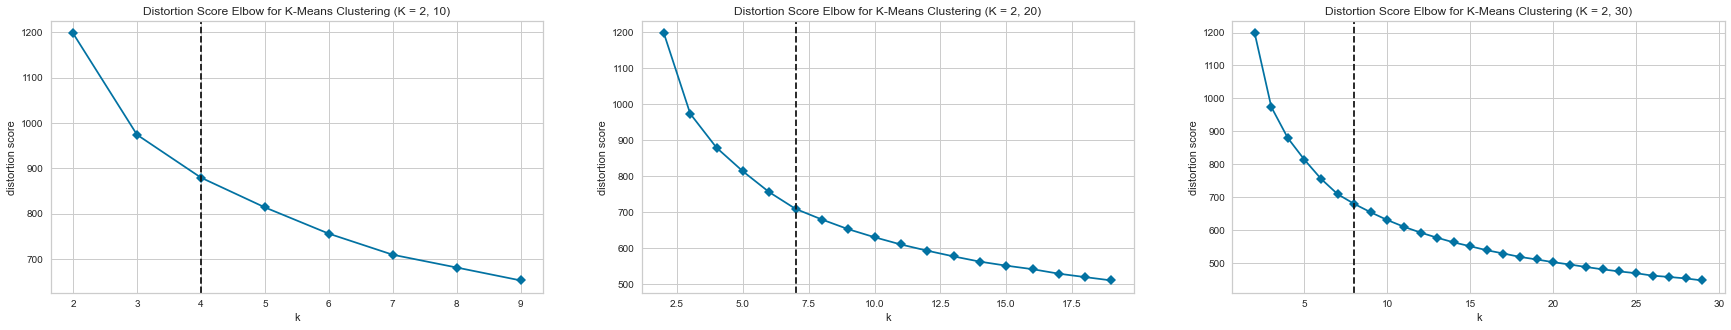

In [73]:
k_start = [2]
k_max = [10, 20, 30]
Ks = []
model = KMeans()

# print the elbow plots
f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))

for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='distortion', timings=False, ax=axs[i])
    vis.fit(X_minmax)  
    axs[i].set_title('Distortion Score Elbow for K-Means Clustering (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('distortion score')
    axs[i].set_xlabel('k')
    #axs[i].legend(['distortion score for k','elbow at k = ' + str(vis.elbow_value_) + ', score = ' + '{:.2f}'.format(vis.elbow_score_)])
    if (vis.elbow_value_ not in Ks) and (vis.elbow_value_ != None):
        Ks.append(vis.elbow_value_)
plt.show()

### Silhouette Method

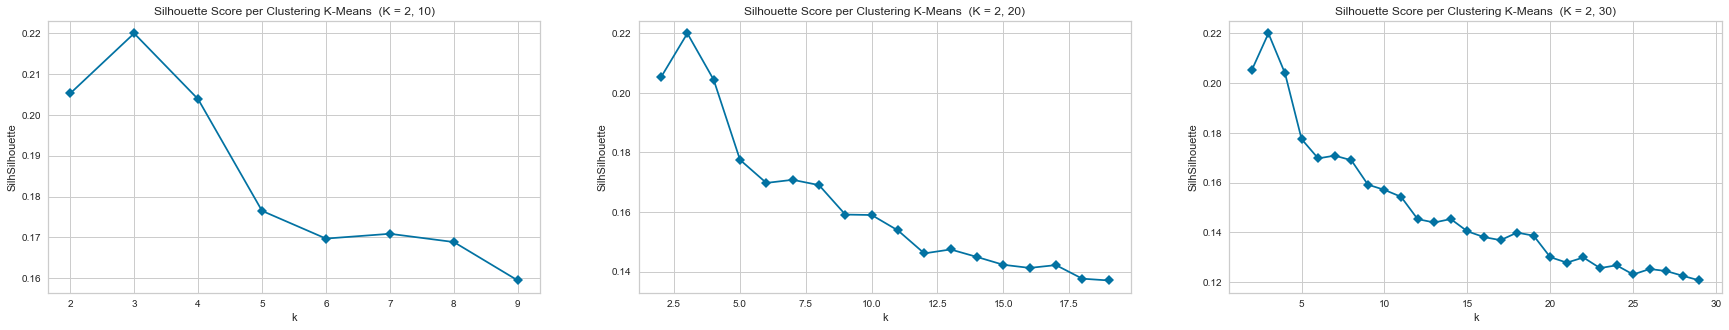

In [74]:
k_start = [2]
k_max = [10, 20, 30]
model = KMeans()

# print the elbow plots
f, axs = plt.subplots(nrows=1, ncols=len(k_max), figsize=(30,5))

for i in range(len(k_max)):
    vis = KElbowVisualizer(model, k=(k_start[0],k_max[i]), metric='silhouette', timings=False, ax=axs[i], locate_elbow=False)
    vis.fit(X_minmax)  
    axs[i].set_title('Silhouette Score per Clustering K-Means  (K = ' + str(k_start[0]) + ', ' + str(k_max[i]) + ')' )
    axs[i].set_ylabel('SilhSilhouette')
    axs[i].set_xlabel('k')
plt.show()

Mostra una silhouette massima per 3,4

In [75]:
k_from_sil = [2,3,6]
for k in k_from_sil:
    if k not in Ks:
        Ks.append(k)        
Ks

[4, 7, 8, 2, 3, 6]

Stampo i valori delll'SSE e della silhouette per ciascun K nei range tra 2-10, 2,20 e 2,30

In [76]:
for k in range(2,10):
    model = KMeans(n_clusters=k, max_iter=1000)
    model.fit(X)
    print(f'K = {k} | SSE: {model.inertia_} | Silohuette: {silhouette_score(X, model.labels_)}')

K = 2 | SSE: 42207.73356673716 | Silohuette: 0.20486816573466135
K = 3 | SSE: 33436.45504355049 | Silohuette: 0.23051454187814668
K = 4 | SSE: 29707.439054552633 | Silohuette: 0.20579730024864434
K = 5 | SSE: 27764.310745170555 | Silohuette: 0.17880058424852047
K = 6 | SSE: 25947.45394006939 | Silohuette: 0.171358524484372
K = 7 | SSE: 24412.893330359257 | Silohuette: 0.1711816487739414
K = 8 | SSE: 23351.59903212753 | Silohuette: 0.16011917164717496
K = 9 | SSE: 22392.80318684736 | Silohuette: 0.15918349590199138


In [77]:
for k in range(2,20):
    model = KMeans(n_clusters=k, max_iter=1000)
    model.fit(X)
    print(f'K = {k} | SSE: {model.inertia_} | Silohuette: {silhouette_score(X, model.labels_)}')

K = 2 | SSE: 42207.84392351085 | Silohuette: 0.2048516948766629
K = 3 | SSE: 33436.45504355049 | Silohuette: 0.23051454187814668
K = 4 | SSE: 29708.191955655224 | Silohuette: 0.2052286648570488
K = 5 | SSE: 27764.151642522556 | Silohuette: 0.1788779909119604
K = 6 | SSE: 25956.6072773633 | Silohuette: 0.17512837099491663
K = 7 | SSE: 24412.93959461318 | Silohuette: 0.17110162990850544
K = 8 | SSE: 23350.20438762962 | Silohuette: 0.16031572957750143
K = 9 | SSE: 22392.68306508139 | Silohuette: 0.1592327622011922
K = 10 | SSE: 21570.540304462396 | Silohuette: 0.1578705504544063
K = 11 | SSE: 20953.25944821872 | Silohuette: 0.15590313821583796
K = 12 | SSE: 20360.491819526567 | Silohuette: 0.1461383755151582
K = 13 | SSE: 19871.24362826327 | Silohuette: 0.13809770362507257
K = 14 | SSE: 19389.43918752661 | Silohuette: 0.13573245938666723
K = 15 | SSE: 18920.8206690922 | Silohuette: 0.13669606757271852
K = 16 | SSE: 18493.23341709422 | Silohuette: 0.13833858510196076
K = 17 | SSE: 18167.36

In [78]:
for k in range(2,30):
    model = KMeans(n_clusters=k, max_iter=1000)
    model.fit(X)
    print(f'K = {k} | SSE: {model.inertia_} | Silohuette: {silhouette_score(X, model.labels_)}')

K = 2 | SSE: 42207.80492087587 | Silohuette: 0.20491821891066478
K = 3 | SSE: 33436.458768620425 | Silohuette: 0.23053407440876114
K = 4 | SSE: 29708.191955655224 | Silohuette: 0.2052286648570488
K = 5 | SSE: 27764.323428020023 | Silohuette: 0.17856713900837562
K = 6 | SSE: 25947.966612875676 | Silohuette: 0.17149816664477693
K = 7 | SSE: 24412.893330359257 | Silohuette: 0.1711816487739414
K = 8 | SSE: 23387.986398914723 | Silohuette: 0.16074203398984144
K = 9 | SSE: 22394.224067418014 | Silohuette: 0.15949658429360183
K = 10 | SSE: 21584.332944737653 | Silohuette: 0.15652461549848237
K = 11 | SSE: 20966.47016397128 | Silohuette: 0.1553708778036325
K = 12 | SSE: 20396.561941924458 | Silohuette: 0.14525296879856342
K = 13 | SSE: 19842.28732430394 | Silohuette: 0.14053773074625694
K = 14 | SSE: 19409.299572129436 | Silohuette: 0.14145481558974426
K = 15 | SSE: 18965.91300325713 | Silohuette: 0.13497473305488197
K = 16 | SSE: 18538.78081660573 | Silohuette: 0.1357023501395688
K = 17 | SSE

### Clustering gerarchico

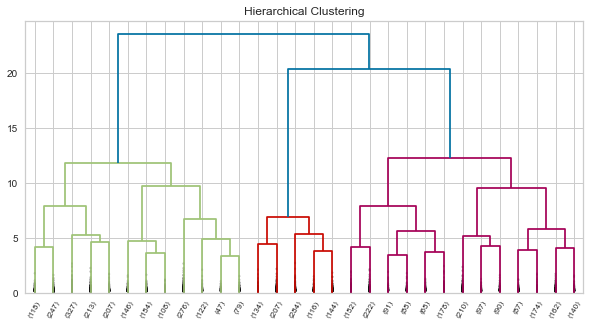

In [79]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 5))
plt.title("Hierarchical Clustering")
plt.axhline(y=80, ls='--', c='red')
dend = dendrogram(linkage(X_minmax, method='ward'), truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

In [80]:
k_ward = 3
if k_ward not in Ks:
    Ks.append(k_ward)

In [81]:
Ks = np.sort(Ks)
Ks

array([2, 3, 4, 6, 7, 8])

In [82]:
X_centers = []
X_labels = []
X_inertia = []

for k in Ks:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100) 
    kmeans.fit(X_minmax) # we perform the clustering for each value of k
    X_centers.append(scaler.inverse_transform(kmeans.cluster_centers_)) # we store the coordinates of the centroids
    X_labels.append(kmeans.labels_) # we store the labels associated with the records
    X_inertia.append(kmeans.inertia_) # we store the SSE value associated with the clustering

In [83]:
int_metrics_K=pd.DataFrame() # we create a dataframe to contain the results of the evaluation

k_cols = []
for k in Ks:
    k_cols.append('K_' + str(k))
    
sse=[]
sil=[]

# wrt categorical features
for i in range(len(Ks)):
    sse.append(X_inertia[i])
    sil.append(silhouette_score(X_minmax, X_labels[i]))

int_metrics_K['K'] = k_cols
int_metrics_K['SSE'] = sse
int_metrics_K['Silhouette'] = sil

int_metrics_K.set_index(['K'], inplace=True)
int_metrics_K

,SSE,Silhouette
K,,
K_2,1197.487145,0.205344
K_3,973.944479,0.219998
K_4,879.373577,0.204397
K_6,755.845146,0.169953
K_7,709.319286,0.170795
K_8,679.760013,0.169101


In [84]:
opt_k = 3
opt_k_index = np.where(Ks == opt_k)[0].item()
opt_k_index

k = Ks[opt_k_index] # it contains the optimal value of k
centers = X_centers[opt_k_index] # it contains the centroids for the optimal value of k
labels = X_labels[opt_k_index] # # it contains the labels for the optimal value of k

***

# Analisi del clustering con k = 3

In [111]:
def autolabel(rects, i = None, j = None):
    if (i != None) and (j!=None): 
        target = axs[i][j]
    elif i != None:
        target = axs[i]
    else:
        target = axs    
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        target.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

In [86]:
df

,word,length,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,polysemy,frequency_log
0,abattoir,8,4.200,2.864,4.333,5.455,4.391,2.382,6.760,4.652,5.391,0,5.204321
1,abbey,5,3.125,5.781,4.667,5.906,5.344,3.324,5.177,5.121,3.303,0,6.625813
2,abbreviate,10,3.273,5.250,5.235,3.286,3.177,5.121,5.543,2.667,3.971,0,5.146454
3,abdicate,8,4.194,3.767,4.419,3.367,2.516,3.971,6.233,4.679,5.167,0,5.093852
4,abdication,10,3.846,3.880,4.800,3.292,2.571,3.097,6.407,5.083,4.571,0,5.107695
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4677,zeppelin,8,6.185,5.000,5.333,6.286,6.185,3.167,6.036,5.464,5.269,0,6.504191
4678,zero,4,4.031,4.182,4.567,2.688,3.903,6.269,2.636,1.758,4.172,0,7.487639
4679,zest,4,5.969,6.818,6.121,4.438,4.033,4.000,5.364,2.636,3.452,0,5.816248
4680,zoo,3,5.909,6.235,5.485,6.118,6.441,5.655,2.324,4.844,4.059,0,7.064068


In [108]:
df = pd.read_csv("normative.csv", skipinitialspace=True)

        
#attr_cluster = ['length', 'arousal', 'valence', 'dominance', 'concreteness', 'familiarity', 'aoa', 'semsize', "frequency_log"]    
attr_cluster = ['valence', 'dominance', 'concreteness', 'aoa', 'semsize']   
#attr_cluster = ['length', 'valence', 'dominance', 'concreteness', 'aoa']     
#attr_cluster = ['length', 'valence', 'dominance', 'concreteness']  
#attr_cluster = ['valence', 'dominance', 'concreteness']  
#attr_cluster = ['valence', 'dominance', 'concreteness', 'familiarity', 'aoa', 'semsize']  
#attr_cluster = [ 'valence', 'dominance', 'concreteness', 'aoa', 'semsize'] #[ 'valence', 'dominance', 'concreteness', 'aoa', 'semsize']   
X = df[attr_cluster]

X_cat = df.drop(columns = ['word','length','arousal','valence', 'dominance','concreteness', 'imageability', 'aoa','familiarity', 'semsize', 'gender', 'frequency_log'  ])
X_num = df[attr_cluster]

scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X) 

df.head()

k = 3
kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100) 
kmeans.fit(X_minmax) # we perform the clustering for each value of k

centers = scaler.inverse_transform(kmeans.cluster_centers_) # it contains the centroids for the optimal value of k
labels = kmeans.labels_ # # it contains the labels for the optimal value of k
X_inertia = kmeans.inertia_

X = X.join(X_cat['polysemy'])
cluster_col = 'K_' + str(k) # it contains the name of the column containing the optimal labels
X[cluster_col] = labels

In [88]:
X.head()

,valence,dominance,concreteness,aoa,semsize,polysemy,K_3
0,2.864,4.333,5.455,6.760,4.652,0,2
1,5.781,4.667,5.906,5.177,5.121,0,0
2,5.250,5.235,3.286,5.543,2.667,0,2
3,3.767,4.419,3.367,6.233,4.679,0,2
4,3.880,4.800,3.292,6.407,5.083,0,2


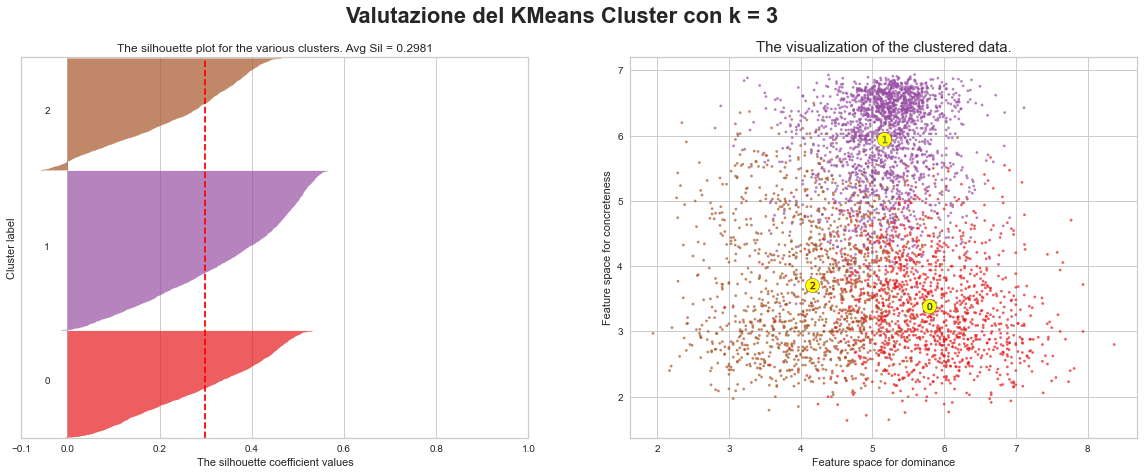

In [112]:

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 7)

# --- PRIMO GRAFICO: analisi silhouette --- #
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
axs[0].set_xlim([-0.1, 1])
# The (k+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
axs[0].set_ylim([0, len(X_minmax) + (k + 1) * 10])

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X_minmax, labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_minmax, labels)
bar_colors = []
y_lower = 10
for i in range(k):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.Set1(float(i) / k)
    bar_colors.append(color)
    axs[0].fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    axs[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples


axs[0].set_title("The silhouette plot for the various clusters. Avg Sil = " + '{:.4f}'.format(silhouette_avg))
axs[0].set_xlabel("The silhouette coefficient values")
axs[0].set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
axs[0].axvline(x=silhouette_avg, color="red", linestyle="--")

axs[0].set_yticks([])  # Clear the yaxis labels / ticks
axs[0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed -------------QUI SI CAMBIANO LE COLONNE
colors = cm.Set1(labels.astype(float) / k)
axs[1].scatter(X[X.columns[1]], X[X.columns[2]], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

# Draw white circles at cluster centers
axs[1].scatter(centers[:, 1], centers[:, 2], marker='o', c="yellow", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    axs[1].scatter(c[1], c[2], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

# ----------------------    QUI SI CAMBIANO LE COLONNE
axs[1].set_title("The visualization of the clustered data.", fontsize=15)
axs[1].set_xlabel("Feature space for " + X.columns[1])
axs[1].set_ylabel("Feature space for " + X.columns[2])

# --- TERZO GRAFICO (ISTOGRAMMA): Dimensione clustering --->
#hist, bins = np.histogram(labels, bins=range(0, len(set(labels)) + 1))
#autolabel(axs[2].bar(list(range(0,len(set(labels)))), hist, color=bar_colors, tick_label=['Cluster 0', 'Cluster 1', 'Cluster 2']), 2)
#axs[2].set_title('Dimension of the clusters')
#axs[2].set_ylabel('Num. of customers')

plt.suptitle(("Valutazione del KMeans Cluster "
              "con k = %d" % k), fontsize=22, fontweight='bold')
plt.show()

### Outliers

In [90]:
negative_sil = silhouette_samples(X_minmax, labels)
negative_sil_colors = []
for i in range(len(negative_sil)):
    if negative_sil[i] < 0:
        negative_sil_colors.append('#3aa9ba')
    elif labels[i] == 0:
        negative_sil_colors.append('#bf0a1f') 
    elif labels[i] == 1:
        negative_sil_colors.append('#5c327d') 
    else:
        negative_sil_colors.append('#85513d')

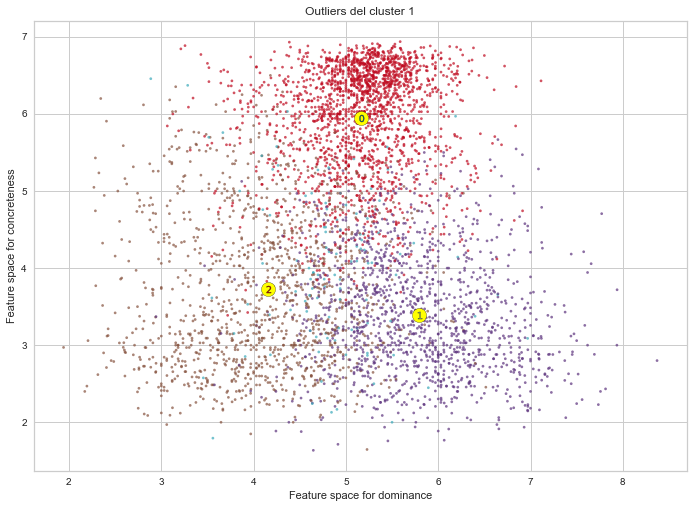

In [91]:
# 2nd Plot showing the actual clusters formed
fig, axs = plt.subplots(1, 1)
axs.scatter(X[X.columns[1]], X[X.columns[2]], marker='.', s=30, lw=0, alpha=0.7, c=negative_sil_colors, edgecolor='k')

# Draw white circles at cluster centers
axs.scatter(centers[:, 1], centers[:, 2], marker='o', c="yellow", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    axs.scatter(c[1], c[2], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

axs.set_title("Outliers del cluster 1") 
axs.set_xlabel("Feature space for " + X.columns[1])
axs.set_ylabel("Feature space for " + X.columns[2])

plt.show()

### Visualizzazione centroidi e clusters

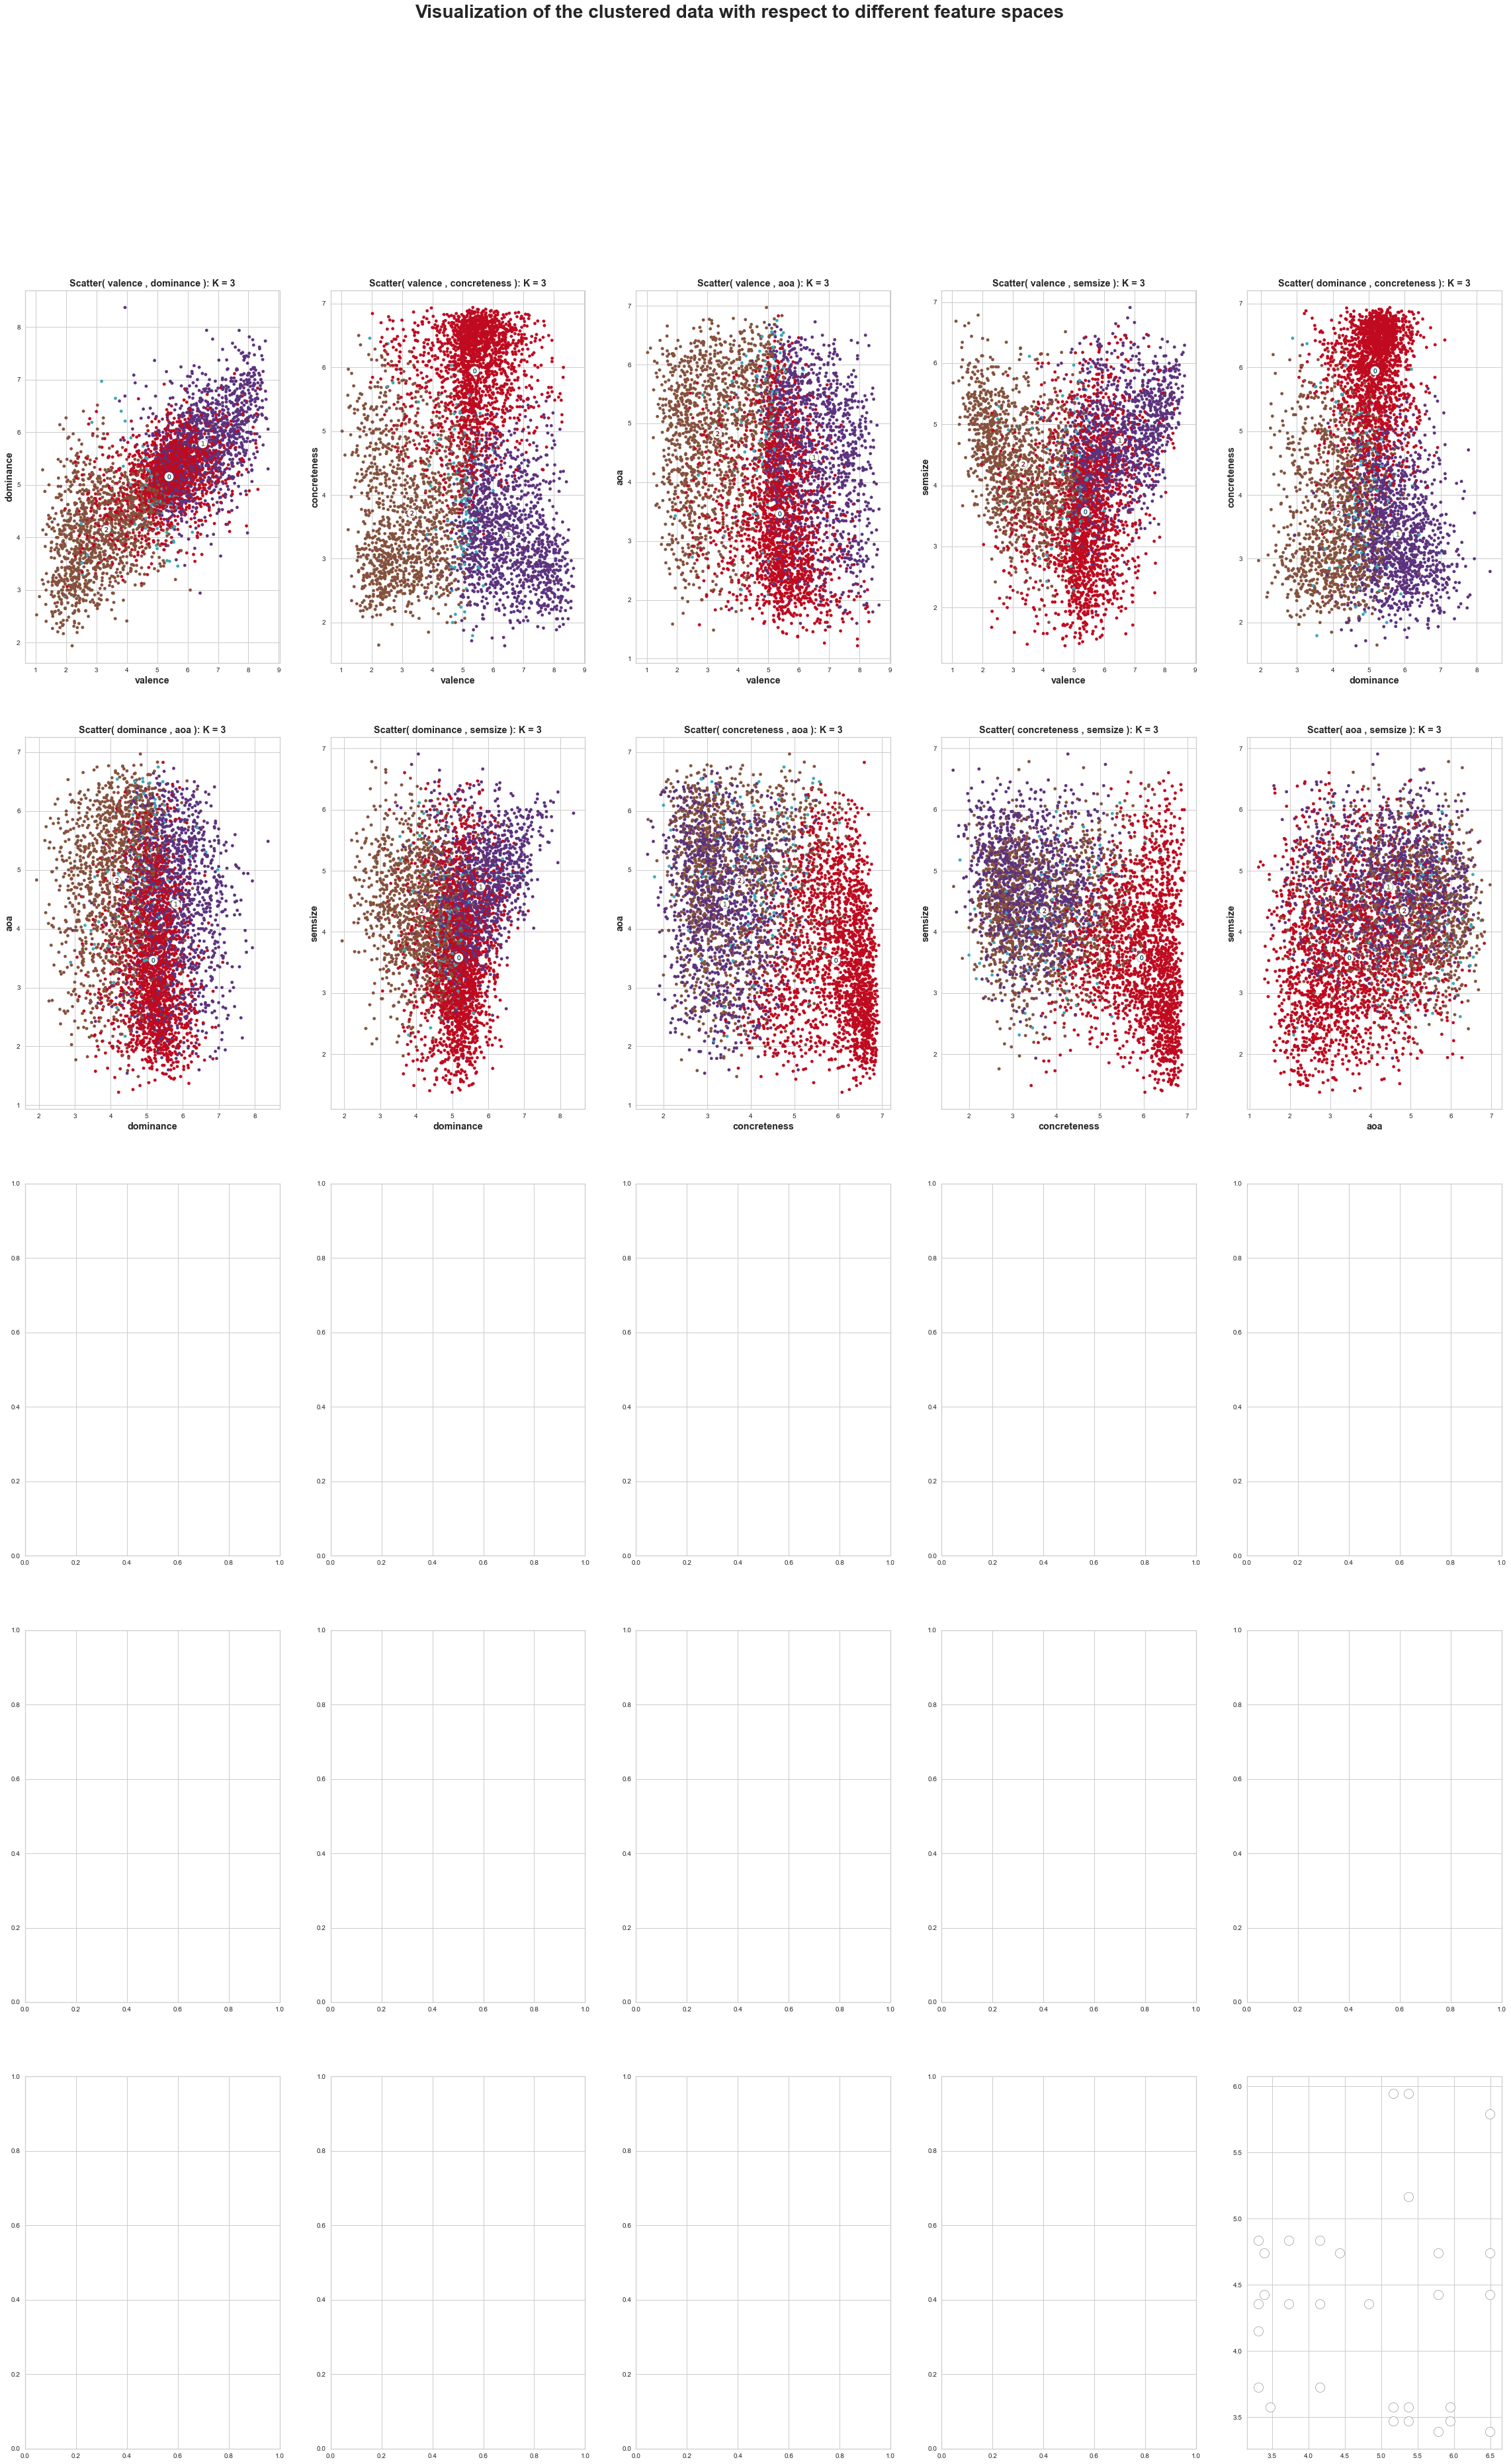

In [92]:
# scatter plots with centroids
f, axs = plt.subplots(nrows=5, ncols=5, figsize=(40,60))
plt.suptitle(("Visualization of the clustered data with respect to different feature spaces"), fontsize=28, fontweight='bold')
plot_id = 0
for i in range(len(X_num.columns)):
    for j in range(i+1, len(X_num.columns)):
        a, b = X.columns[i], X.columns[j]       
        axs[int(plot_id/5)][plot_id%5].scatter(X[a], X[b], c=negative_sil_colors, s=20)
        for h in range(len(centers)):          
            plt.scatter(centers[h][X.columns.get_loc(a)], centers[h][X.columns.get_loc(b)], marker='o', c="white", alpha=1, s=200, edgecolor='k')
            axs[int(plot_id/5)][plot_id%5].scatter(centers[h][X.columns.get_loc(a)], centers[h][X.columns.get_loc(b)], marker='o', c="white", alpha=1, s=200, edgecolor='k')
            axs[int(plot_id/5)][plot_id%5].scatter(centers[h][X.columns.get_loc(a)], centers[h][X.columns.get_loc(b)], marker='$%d$' % h, alpha=1, s=50, edgecolor='k')    
        axs[int(plot_id/5)][plot_id%5].set_title('Scatter( ' + a + ' , ' + b + ' ): K = ' + str(k), fontdict={'fontsize': 'x-large', 'fontweight' : 'bold'})
        axs[int(plot_id/5)][plot_id%5].set_xlabel(a, fontdict={'fontsize': 'x-large', 'fontweight' : 'bold'})
        axs[int(plot_id/5)][plot_id%5].set_ylabel(b, fontdict={'fontsize': 'x-large', 'fontweight' : 'bold'})
        plot_id = plot_id +1
plt.show()

#### Parralel coordinates

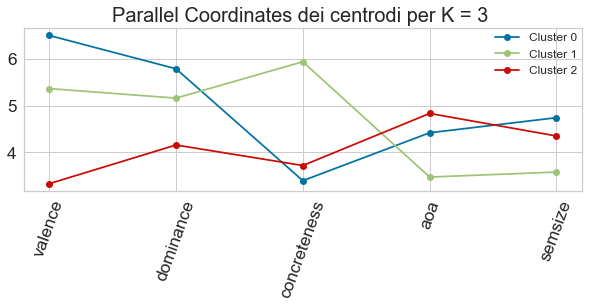

In [118]:
plt.figure(figsize=(10,3))

xlabels = ["0"] + list(X.columns)
N = len(X.columns)

for j in range(0, len(centers)):
    plt.plot(centers[j], marker='o', label='Cluster %s' % j)
    
plt.xticks(range(0,len(X_num.columns)), X_num.columns, fontsize= 20, rotation=70)
plt.tick_params(labelsize='xx-large')
plt.legend(fontsize=12, loc='best', borderaxespad=0.)
plt.title('Parallel Coordinates dei centrodi per K = 3 ' , fontsize=20)

plt.show()

***

## Valutazione del clustering

In [94]:
ext_metrics=pd.DataFrame()

temp=[]
sim=[]
hom=[]
compl=[]
mutinfo=[]

# wrt categorical features
for column in X_cat:
    temp.append(column)
    sim.append(metrics.adjusted_rand_score(X_cat[column], X[cluster_col]))
    hom.append(metrics.homogeneity_score(X_cat[column], X[cluster_col]))
    compl.append(metrics.completeness_score(X_cat[column], X[cluster_col]))
    mutinfo.append(metrics.normalized_mutual_info_score(X_cat[column], X[cluster_col], average_method='arithmetic'))

ext_metrics['Feature'] = temp
ext_metrics['Similarity'] = sim
ext_metrics['Homogeneity'] = hom
ext_metrics['Completeness'] = compl
ext_metrics['Mutual Information'] = mutinfo

ext_metrics.set_index(['Feature'], inplace=True)
ext_metrics

,Similarity,Homogeneity,Completeness,Mutual Information
Feature,,,,
polysemy,-0.01078,0.042271,0.010987,0.017441


In [95]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X, kmeans.labels_)) #misura per identificare se un clsuter è ben seaprato dagli altri e connessioni interne
#maggiroe è la Silouhette migliore è il clsuter da 0 a 1

SSE 537.1479661015761
Silhouette 0.3379925043061359


In [96]:
#int_metrics_K.loc['K_3']

### Analisi qualitativa

In [97]:
X.head()

,valence,dominance,concreteness,aoa,semsize,polysemy,K_3
0,2.864,4.333,5.455,6.760,4.652,0,2
1,5.781,4.667,5.906,5.177,5.121,0,0
2,5.250,5.235,3.286,5.543,2.667,0,2
3,3.767,4.419,3.367,6.233,4.679,0,2
4,3.880,4.800,3.292,6.407,5.083,0,2


In [1]:
df_cat = pd.read_csv("normative.csv", skipinitialspace=True)

df_cat['length_cat'] = pd.qcut(df_cat['length'], 4, labels=["corte", "medie", "lunghe", "molto lunghe"])
df_cat['familiarity_cat'] = pd.qcut(df_cat['familiarity'], 4, labels=["molto poco familiare", "poco familiare", "familiare", "molto familiare"])
df_cat['frequency_cat'] = pd.qcut(df_cat['frequency_log'], 4, labels=["poco frequente", "medio frequente", "frequente", "molto frequente"])
df_cat['arousal_cat'] = pd.qcut(df_cat['arousal'], 4, labels=["molto calmante", "calmante", "eccitante", "molto eccitante"])

NameError: name 'pd' is not defined

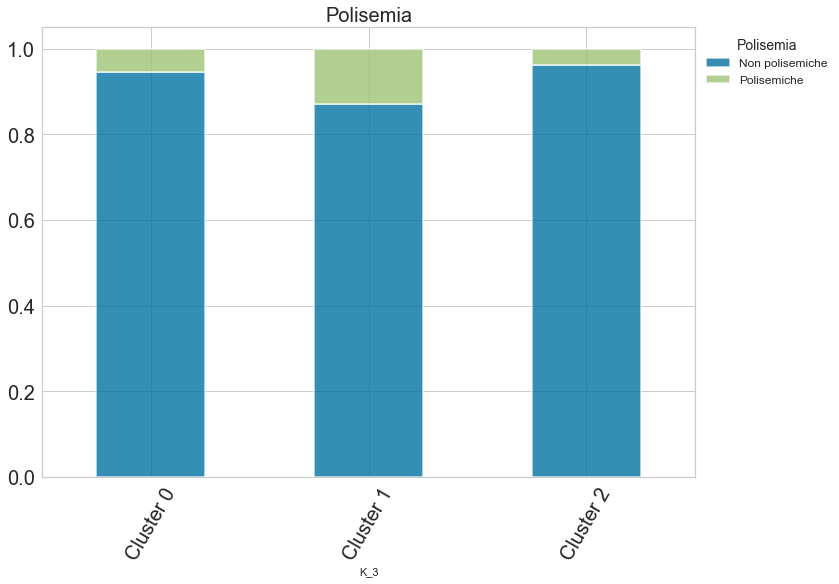

In [120]:
bar_pl = df['polysemy'].groupby(X['K_3']).value_counts(normalize = True).unstack(1)
bar_pl.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)
plt.xticks([0, 1, 2],['Cluster 0', 'Cluster 1', 'Cluster 2'], rotation = 60, fontsize=20)
plt.yticks(fontsize=20)
plt.title("Polisemia", fontsize = 20)
plt.legend(["Non polisemiche", "Polisemiche"],bbox_to_anchor =(1,1), title = 'Polisemia', title_fontsize = 14, fontsize = 12)



plt.show()

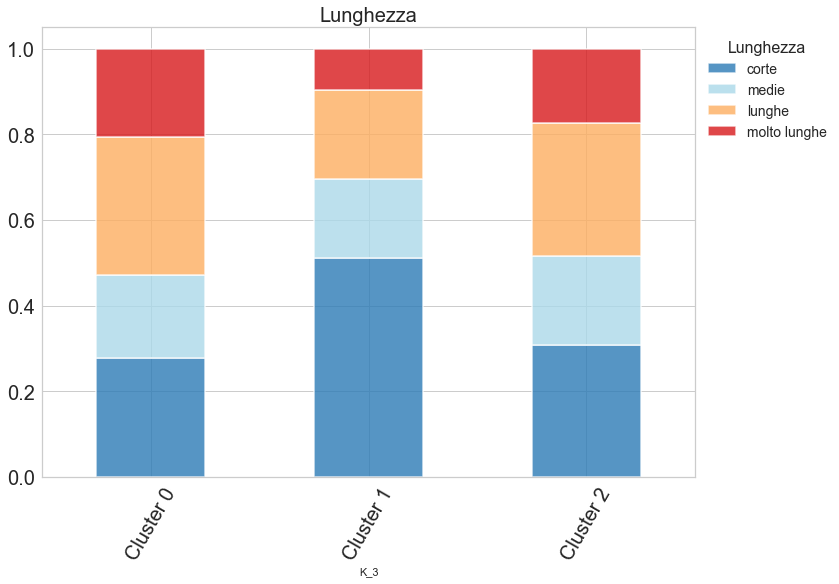

In [124]:
bar_pl1 = df_cat['length_cat'].groupby(X['K_3']).value_counts(normalize = True).unstack(1)

bar_pl1.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, color = ['#2c7bb6', '#abd9e9', '#fdae61', '#d7191c'] )
plt.xticks([0, 1, 2],['Cluster 0', 'Cluster 1', 'Cluster 2'], rotation = 60, fontsize=20, )
plt.yticks(fontsize=20)
plt.title("Lunghezza", fontsize = 20)
plt.legend(bbox_to_anchor =(1,1), title = 'Lunghezza', title_fontsize = 16, fontsize = 14)



plt.show()

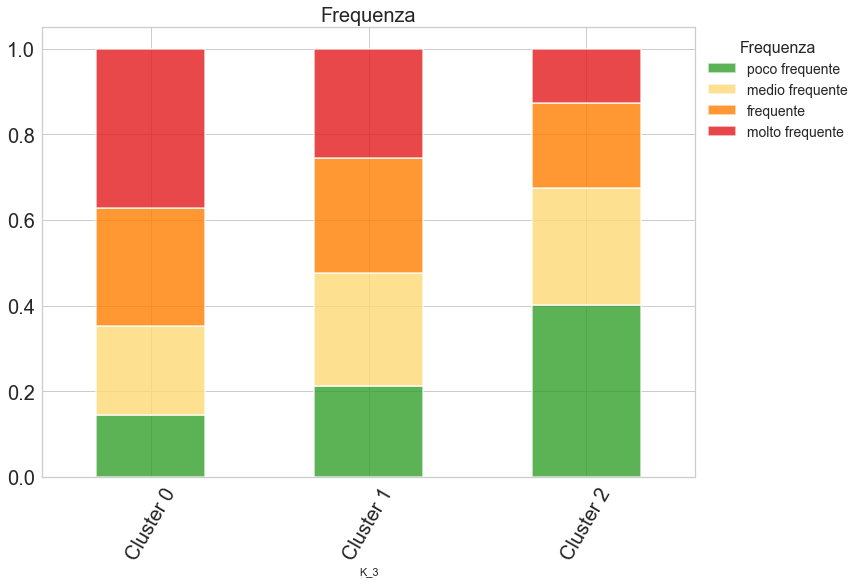

In [126]:

bar_pl1 = df_cat['frequency_cat'].groupby(X['K_3']).value_counts(normalize = True).unstack(1)

bar_pl1.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, color = ['#33a02c', '#fed976','#ff7f00','#e31a1c'])
plt.xticks([0, 1, 2],['Cluster 0', 'Cluster 1', 'Cluster 2'], rotation = 60, fontsize=20)
plt.yticks(fontsize=20)
plt.title("Frequenza", fontsize = 20)
plt.legend(bbox_to_anchor =(1,1), title = 'Frequenza', title_fontsize = 16, fontsize = 14)

#["#41b6c4","#1d91c0","#225ea8","#253494"]


plt.show()

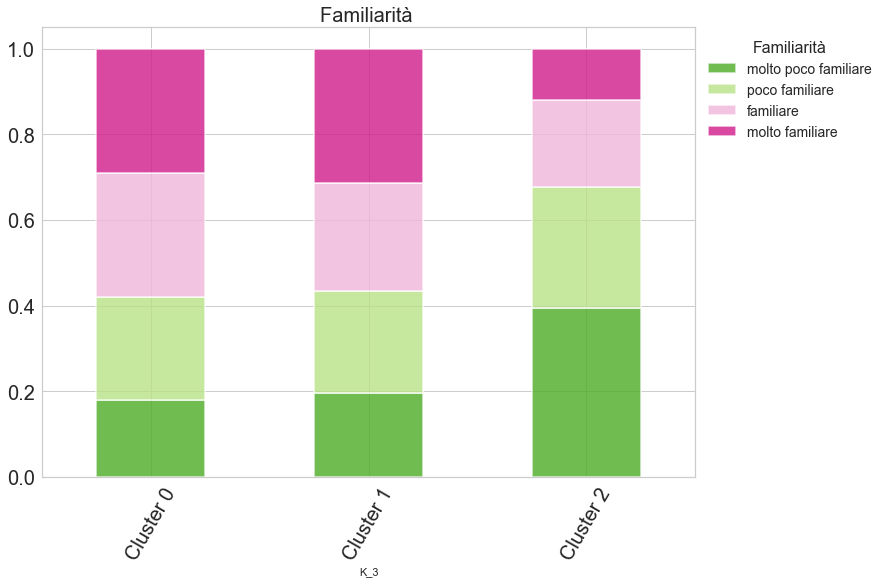

In [127]:

bar_pl1 = df_cat['familiarity_cat'].groupby(X['K_3']).value_counts(normalize = True).unstack(1)

bar_pl1.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, color = ['#4dac26', '#b8e186', '#f1b6da', '#d01c8b']


)
plt.xticks([0, 1, 2],['Cluster 0', 'Cluster 1', 'Cluster 2'], rotation = 60, fontsize=20)
plt.yticks(fontsize=20)
plt.title("Familiarità ", fontsize = 20)
plt.legend(bbox_to_anchor =(1,1), title = 'Familiarità', title_fontsize = 16, fontsize = 14)



plt.show()

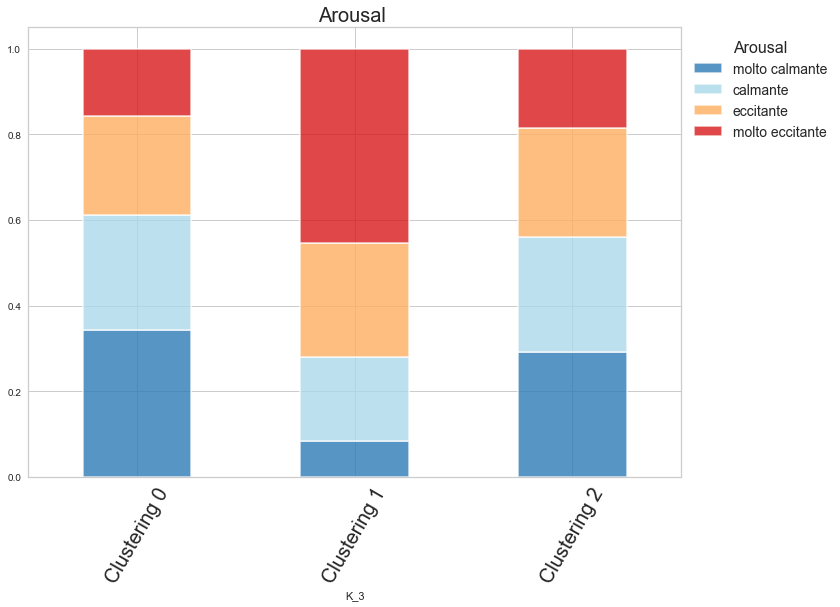

In [103]:

bar_pl1 = df_cat['arousal_cat'].groupby(X['K_3']).value_counts(normalize = True).unstack(1)

bar_pl1.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, color = ['#2c7bb6', '#abd9e9', '#fdae61', '#d7191c'] )
plt.xticks([0, 1, 2],['Clustering 0', 'Clustering 1', 'Clustering 2'], rotation = 60, fontsize=20)
plt.title("Arousal ", fontsize = 20)
plt.legend(bbox_to_anchor =(1,1), title = 'Arousal', title_fontsize = 16, fontsize = 14)



plt.show()

In [104]:
type(list(df['word']))

list

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aliis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\aliis\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


NOUN :  2945
ADJ :  1082
VERB :  476
ADP :  49
ADV :  98
DET :  6
NUM :  5
PRT :  1
PRON :  5
X :  12
CONJ :  3


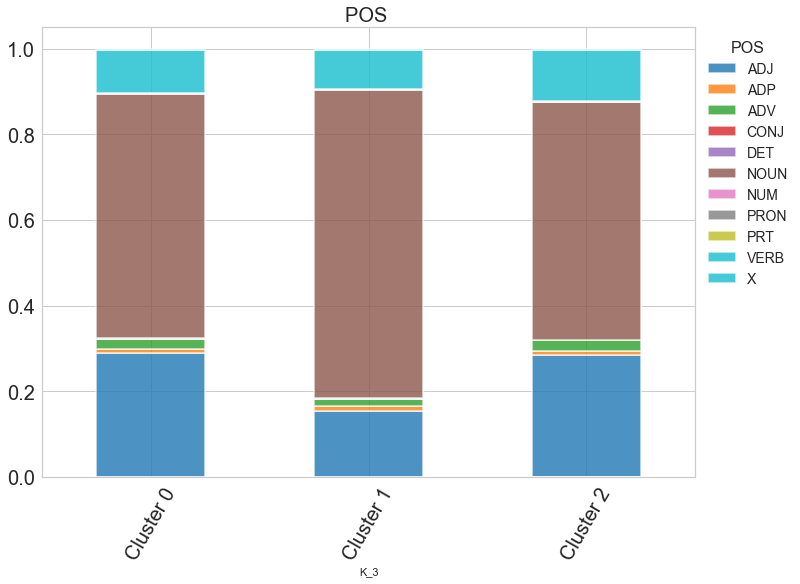

In [135]:
from nltk import *
download('averaged_perceptron_tagger')
download('universal_tagset')

POS = nltk.pos_tag(list(df['word']), tagset='universal')
POS_list = []

for word, tag in POS:
    POS_list.append(tag)
POS_list

POS_col = 'pos_tagging' # it contains the name of the column containing the optimal labels
X[POS_col] = POS_list
df_cat[POS_col] = POS_list

for el in df_cat['pos_tagging'].unique():
    print(el,': ', POS_list.count(el))
    
bar_pl = df_cat['pos_tagging'].groupby(X['K_3']).value_counts(normalize = True).unstack(1)

bar_pl.plot(kind='bar',stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, colormap = 'tab10')
plt.xticks([0, 1, 2],['Cluster 0', 'Cluster 1', 'Cluster 2'], rotation = 60, fontsize=20)
plt.yticks(fontsize=20)
plt.title("POS ", fontsize = 20)
plt.legend(bbox_to_anchor =(1,1), title = 'POS', title_fontsize = 16, fontsize = 14)
#plt.legend(bbox_to_anchor =(1,1))
#plt.legend([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['Aggettivo', 'Preposizione', 'Avverbio', 'Congiunzione', 'Determinante', 'Nome', 'Numerale', 'Pronome', 'Particella', 'Verbo', 'Altro'])



plt.show()